In [3]:
#IMPORTS
import pandas as pd
import numpy as np
import datetime

#import raw revenue data
df_2016 = pd.read_csv("../../raw_data/orders2016.csv", sep=";")
df_2017 = pd.read_csv("../../raw_data/orders2017.csv", sep=";")
df_2018 = pd.read_csv("../../raw_data/orders2018.csv", sep=";")
df_2019 = pd.read_csv("../../raw_data/orders2019.csv", sep=";")
df_2020 = pd.read_csv("../../raw_data/orders2020.csv", sep=";")
df_2021 = pd.read_csv("../../raw_data/orders2021.csv", sep=";")
df_2022 = pd.read_csv("../../raw_data/orders2022.csv", sep=";")

df_list = [df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022]

#Dropping unnecessary columns, grouping by "date", summing "item_price" to get daily revenues

for i, df in enumerate(df_list):
    df_list[i] = pd.DataFrame(df.groupby(by="date")["item_price"].sum()/100)

#Concat all data in one dataframe, rename the columns for prophet

df = pd.concat(df_list, ignore_index=False)
df = df.rename(columns={"date": "ds", "item_price": "y"})
df["ds"] = df.index
df = df.reset_index(drop=True)
df = df[["ds","y"]]
df

#turning the ds (date) column into datetime

df['ds']=pd.to_datetime(df['ds'])

##Importing and preprocessing feature data

#weather
weather_df = pd.read_csv("../../feature_data/weather.csv")
weather_df = weather_df.drop(columns=["dt","timezone","city_name","lat","lon","sea_level","grnd_level","weather_icon","rain_3h","snow_3h"])
weather_df = weather_df.rename(columns={"dt_iso":"ds"})
weather_df['ds'] = weather_df['ds'].str[:19]
# Convert to datetime format
weather_df["ds"] = pd.to_datetime(weather_df["ds"])
# Drop all rows where the time component of 'column1' is not 12:00:00
weather_df = weather_df[weather_df['ds'].dt.time == pd.to_datetime('12:00:00').time()]
weather_df["ds"] = pd.to_datetime(weather_df["ds"].dt.date)
df['ds'] = pd.to_datetime(df['ds'])

merged_df = pd.merge(df,weather_df,on="ds",how="left")

##holiday
df_holiday= pd.read_csv("../../feature_data/holidays.csv", sep=",")

#change ds datatype in df_Holiday
df_holiday['ds']=pd.to_datetime(df_holiday['ds'])

#merge holiday to df
merged_df = pd.merge(merged_df, df_holiday, how='left', left_on='ds', right_on='ds')

#replace nan value with 0
merged_df['Holiday'] = merged_df['Holiday'].fillna(0)

##inflation
df_inflation_rate= pd.read_csv("../../feature_data/inflation_rate.csv", sep=",")

#change ds datatype in df_Inflation_rate
df_inflation_rate['ds']=pd.to_datetime(df_inflation_rate['ds'])

#merge inflation to df
merged_df= pd.merge(merged_df, df_inflation_rate, how='left', left_on='ds', right_on='ds')

##consumption climate
df_consumption_climate = pd.read_csv("../../feature_data/consumption_climate.csv")
df_consumption_climate = df_consumption_climate.reset_index()
df_consumption_climate['Date'] = pd.to_datetime(df_consumption_climate['Date'])
df_consumption_climate = df_consumption_climate.set_index('Date')
df_consumption_climate = df_consumption_climate.resample('D').ffill().reset_index()
df_consumption_climate = df_consumption_climate.drop(columns=['index'])
df_consumption_climate = df_consumption_climate.rename(columns={'Date': 'ds'})
merged_df = pd.merge(merged_df, df_consumption_climate,on="ds",how="left")

##Covid Lockdowns
merged_df['cov_lock'] = ((merged_df['ds'] >= pd.to_datetime("2020-03-22")) & (merged_df['ds'] <= pd.to_datetime("2020-04-21"))) | ((merged_df['ds'] >= pd.to_datetime("2020-12-16")) & (merged_df['ds'] <= pd.to_datetime("2021-01-09"))) | ((merged_df['ds'] >= pd.to_datetime("2020-04-22")) & (merged_df['ds'] <= pd.to_datetime("2020-05-03"))) | ((merged_df['ds'] >= pd.to_datetime("2020-10-10")) & (merged_df['ds'] <= pd.to_datetime("2020-12-15"))) | ((merged_df['ds'] >= pd.to_datetime("2021-03-31")) & (merged_df['ds'] <= pd.to_datetime("2021-05-18"))) | ((merged_df['ds'] >= pd.to_datetime("2021-11-02")) & (merged_df['ds'] <= pd.to_datetime("2021-12-09")))
merged_df['cov_lock'] = merged_df['cov_lock'].astype(int)

#Berlin Unemployment Mitte and Mitte Mitte
df_unemp_ber= pd.read_csv("../../feature_data/berlin_unemployment.csv", sep=";")
df_unemp_ber['Date'] = pd.to_datetime(df_unemp_ber['Date'], format='%d/%m/%Y')
df_unemp_ber[['unemp_Berlin_Mitte', 'unemp_Berlin_Mitte_Mitte']] = df_unemp_ber[['unemp_Berlin_Mitte', 'unemp_Berlin_Mitte_Mitte']].apply(lambda x: x.str.replace(',', '.'))
df_unemp_ber = df_unemp_ber.astype({"unemp_Berlin_Mitte": float, "unemp_Berlin_Mitte_Mitte": float})
df_unemp_ber[['unemp_Berlin_Mitte', 'unemp_Berlin_Mitte_Mitte']] = df_unemp_ber[['unemp_Berlin_Mitte', 'unemp_Berlin_Mitte_Mitte']].div(100)
df_unemp_ber.set_index('Date', inplace=True)
df_unemp_ber = df_unemp_ber.resample('D').ffill()

merged_df = pd.merge(merged_df, df_unemp_ber, how='left', left_on='ds', right_on='Date')

#foot traffic
foottraffic_2021 = pd.read_csv("../../feature_data/foottraffic2021.csv", sep=";")
foottraffic_2022 = pd.read_csv("../../feature_data/foottraffic2022.csv", sep=";")
foottraffic_2023 = pd.read_csv("../../feature_data/foottraffic2023.csv", sep=";")

foottraffic_list = [foottraffic_2021, foottraffic_2022, foottraffic_2023]

foottraffic_df = pd.concat(foottraffic_list, ignore_index=False)
foottraffic_df = foottraffic_df.rename(columns={"time of measurement": "ds", "pedestrians count": "pedestrians"})
foottraffic_df = foottraffic_df[["ds","pedestrians"]]

foottraffic_df['ds'] = pd.to_datetime(foottraffic_df['ds'], utc=True)
foottraffic_df['ds'] = foottraffic_df['ds'].dt.date
foottraffic_df['ds'] = pd.to_datetime(foottraffic_df['ds'])

merged_df = pd.merge(merged_df, foottraffic_df, how='left', left_on='ds', right_on='ds')

KeyError: 'ds'

In [10]:
merged_df.head()

,ds,y,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,...,weather_id,weather_main,weather_description,Holiday,inflation_rate,Consumption Climate,cov_lock,unemp_Berlin_Mitte,unemp_Berlin_Mitte_Mitte,pedestrians
0,2016-09-01,365.9,25.90,10000.0,9.28,25.46,25.63,26.03,1019,35,...,800,Clear,sky is clear,1.0,0.5,10.0,0,0.095,0.103,NaN
1,2016-09-02,358.6,22.18,9999.0,10.02,21.65,21.92,23.96,1020,46,...,803,Clouds,broken clouds,1.0,0.5,10.0,0,0.095,0.103,NaN
2,2016-09-03,487.5,24.94,9999.0,10.79,24.56,24.92,25.03,1016,41,...,802,Clouds,scattered clouds,0.0,0.5,10.0,0,0.095,0.103,NaN
3,2016-09-04,90.9,19.94,9999.0,14.96,19.90,19.01,19.96,1010,73,...,500,Rain,light rain,0.0,0.5,10.0,0,0.095,0.103,NaN
4,2016-09-05,125.0,19.94,9999.0,14.96,19.90,19.01,19.96,1014,73,...,500,Rain,light rain,0.0,0.5,10.0,0,0.095,0.103,NaN


In [11]:
corr = merged_df.corr()
corr

/tmp/ipykernel_37648/712612077.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = merged_df.corr()


,y,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,...,snow_1h,clouds_all,weather_id,Holiday,inflation_rate,Consumption Climate,cov_lock,unemp_Berlin_Mitte,unemp_Berlin_Mitte_Mitte,pedestrians
y,1.000000,0.539447,0.181595,0.256018,0.524949,0.553452,0.530134,0.080930,-0.479453,-0.101089,...,0.926569,-0.310992,0.204534,0.216035,-0.136553,0.208409,-0.212692,-0.207748,-0.125024,-0.099776
temp,0.539447,1.000000,0.306040,0.731064,0.994918,0.995225,0.995615,-0.097083,-0.592795,-0.117452,...,0.294561,-0.450694,0.219728,0.181068,0.102462,-0.174945,-0.150280,0.029256,0.006818,0.083796
visibility,0.181595,0.306040,1.000000,0.084793,0.303518,0.296716,0.312289,-0.003426,-0.433967,0.051560,...,-0.081212,-0.322782,0.299785,-0.000736,0.105651,-0.135434,0.030664,0.035775,0.002196,0.037294
dew_point,0.256018,0.731064,0.084793,1.000000,0.765117,0.726079,0.732279,-0.228475,0.098250,-0.105692,...,0.380523,0.010171,-0.117396,0.175792,0.116527,-0.159772,-0.170735,0.111434,0.068584,0.139720
feels_like,0.524949,0.994918,0.303518,0.765117,1.000000,0.989087,0.991524,-0.100590,-0.550712,-0.136579,...,0.198178,-0.428522,0.204850,0.180480,0.107347,-0.183952,-0.143018,0.036669,0.009697,0.097514
temp_min,0.553452,0.995225,0.296716,0.726079,0.989087,1.000000,0.986652,-0.077466,-0.587918,-0.116436,...,0.346594,-0.441925,0.221191,0.179743,0.073724,-0.134405,-0.164706,0.006515,-0.001969,0.094407
temp_max,0.530134,0.995615,0.312289,0.732279,0.991524,0.986652,1.000000,-0.116349,-0.588576,-0.109643,...,0.347397,-0.448460,0.215643,0.188226,0.126986,-0.204801,-0.139874,0.036940,0.003552,0.091324
pressure,0.080930,-0.097083,-0.003426,-0.228475,-0.100590,-0.077466,-0.116349,1.000000,-0.138144,-0.218537,...,-0.512041,-0.069511,0.203427,-0.063695,-0.225211,0.226431,-0.086640,-0.127129,-0.033420,0.007696
humidity,-0.479453,-0.592795,-0.433967,0.098250,-0.550712,-0.587918,-0.588576,-0.138144,1.000000,0.023128,...,0.432796,0.680374,-0.493774,-0.052291,-0.030710,0.090508,0.021258,0.065596,0.056076,0.067603
wind_speed,-0.101089,-0.117452,0.051560,-0.105692,-0.136579,-0.116436,-0.109643,-0.218537,0.023128,1.000000,...,0.624368,0.134459,-0.164440,0.015584,-0.023518,0.034471,0.022107,-0.034311,-0.027092,-0.016419


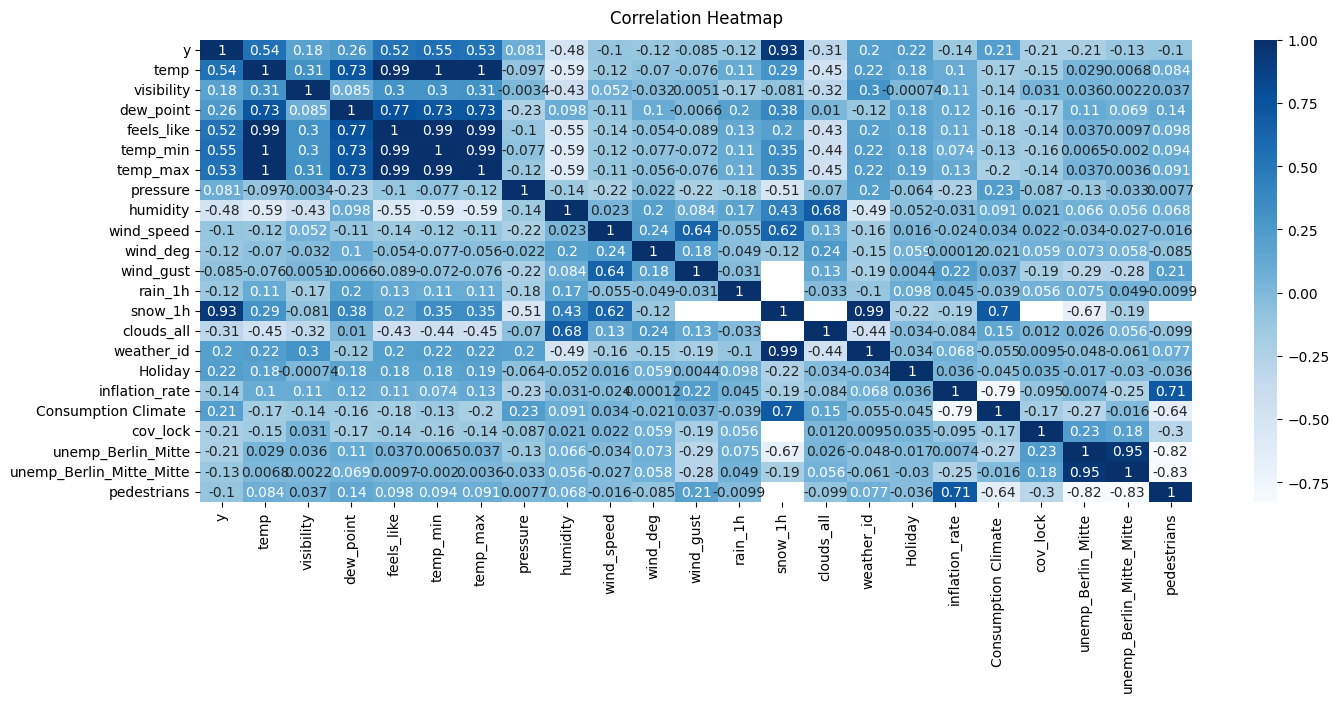

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(corr, cmap="Blues", annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

plt.show()

In [13]:
corr["y"].sort_values(ascending=False)

y                           1.000000
snow_1h                     0.926569
temp_min                    0.553452
temp                        0.539447
temp_max                    0.530134
feels_like                  0.524949
dew_point                   0.256018
Holiday                     0.216035
Consumption Climate         0.208409
weather_id                  0.204534
visibility                  0.181595
pressure                    0.080930
wind_gust                  -0.084906
pedestrians                -0.099776
wind_speed                 -0.101089
wind_deg                   -0.120277
rain_1h                    -0.121435
unemp_Berlin_Mitte_Mitte   -0.125024
inflation_rate             -0.136553
unemp_Berlin_Mitte         -0.207748
cov_lock                   -0.212692
clouds_all                 -0.310992
humidity                   -0.479453
Name: y, dtype: float64

In [14]:
prefinal_df = merged_df.drop(columns=["snow_1h","inflation_rate","pedestrians","unemp_Berlin_Mitte_Mitte"])

In [15]:
prefinal_df.head()

,ds,y,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,...,wind_gust,rain_1h,clouds_all,weather_id,weather_main,weather_description,Holiday,Consumption Climate,cov_lock,unemp_Berlin_Mitte
0,2016-09-01,365.9,25.90,10000.0,9.28,25.46,25.63,26.03,1019,35,...,NaN,NaN,0,800,Clear,sky is clear,1.0,10.0,0,0.095
1,2016-09-02,358.6,22.18,9999.0,10.02,21.65,21.92,23.96,1020,46,...,NaN,NaN,75,803,Clouds,broken clouds,1.0,10.0,0,0.095
2,2016-09-03,487.5,24.94,9999.0,10.79,24.56,24.92,25.03,1016,41,...,NaN,NaN,40,802,Clouds,scattered clouds,0.0,10.0,0,0.095
3,2016-09-04,90.9,19.94,9999.0,14.96,19.90,19.01,19.96,1010,73,...,NaN,NaN,75,500,Rain,light rain,0.0,10.0,0,0.095
4,2016-09-05,125.0,19.94,9999.0,14.96,19.90,19.01,19.96,1014,73,...,NaN,0.21,40,500,Rain,light rain,0.0,10.0,0,0.095


,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1472688000,2016-09-01 00:00:00 +0000 UTC,7200,Berlin,52.520007,13.404954,16.78,10000.0,9.94,16.18,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
1,1472691600,2016-09-01 01:00:00 +0000 UTC,7200,Berlin,52.520007,13.404954,15.84,10000.0,9.95,15.26,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
2,1472695200,2016-09-01 02:00:00 +0000 UTC,7200,Berlin,52.520007,13.404954,15.77,10000.0,8.98,15.07,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
3,1472698800,2016-09-01 03:00:00 +0000 UTC,7200,Berlin,52.520007,13.404954,13.06,10000.0,8.93,12.41,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
4,1472702400,2016-09-01 04:00:00 +0000 UTC,7200,Berlin,52.520007,13.404954,12.05,10000.0,8.71,11.40,...,NaN,NaN,NaN,NaN,NaN,0,741,Fog,fog,50n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56274,1669143600,2022-11-22 19:00:00 +0000 UTC,3600,Berlin,52.520007,13.404954,1.58,7000.0,0.42,-2.42,...,NaN,0.25,NaN,NaN,NaN,100,500,Rain,light rain,10n
56275,1669147200,2022-11-22 20:00:00 +0000 UTC,3600,Berlin,52.520007,13.404954,1.59,7000.0,0.43,-2.06,...,NaN,0.25,NaN,NaN,NaN,100,500,Rain,light rain,10n
56276,1669150800,2022-11-22 21:00:00 +0000 UTC,3600,Berlin,52.520007,13.404954,1.55,7000.0,-0.05,-2.10,...,NaN,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
56277,1669154400,2022-11-22 22:00:00 +0000 UTC,3600,Berlin,52.520007,13.404954,1.61,6000.0,0.00,-1.67,...,5.81,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n


In [7]:
weather_df = weather_df.drop(columns=["dt","timezone","city_name","lat","lon","sea_level","grnd_level","weather_icon","rain_3h","snow_3h"])
weather_df = weather_df.rename(columns={"dt_iso":"ds"})
weather_df['ds'] = weather_df['ds'].str[:19]
# Convert to datetime format
weather_df["ds"] = pd.to_datetime(weather_df["ds"])


KeyError: "['dt', 'timezone', 'city_name', 'lat', 'lon', 'sea_level', 'grnd_level', 'weather_icon', 'rain_3h', 'snow_3h'] not found in axis"

In [89]:
#Ayham 09.03.2023
# Convert the date column to datetime format
weather_df['ds'] = pd.to_datetime(weather_df['ds'], format='%Y-%m-%d %H:%M:%S')

# Filter the rows between 8 am and 10 pm
df_filtered = weather_df[(weather_df['ds'].dt.hour >= 8) & (weather_df['ds'].dt.hour <= 22)]
#group by mean sum and median 
df_filtered['mean_rain'] = df_filtered.groupby(pd.Grouper(key='ds', freq='D'))['rain_1h'].transform('mean')
df_filtered['sum_rain'] = df_filtered.groupby(pd.Grouper(key='ds', freq='D'))['rain_1h'].transform('sum')
df_filtered['median_rain'] = df_filtered.groupby(pd.Grouper(key='ds', freq='D'))['rain_1h'].transform('median')
#select only the 12 o
df_filtered = df_filtered[df_filtered['ds'].dt.time == pd.to_datetime('12:00:00').time()]
# Extract only the date portion
df_filtered['ds'] = pd.to_datetime(df_filtered['ds'])
df_filtered['ds'] = df_filtered['ds'].dt.date
#change the df to datatype
df_filtered['ds'] = pd.to_datetime(df_filtered['ds'])
#join the original data to the filtered 
merged_df = pd.merge(df,df_filtered,on="ds",how="left")



/tmp/ipykernel_37648/1838515546.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['mean_rain'] = df_filtered.groupby(pd.Grouper(key='ds', freq='D'))['rain_1h'].transform('mean')
/tmp/ipykernel_37648/1838515546.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sum_rain'] = df_filtered.groupby(pd.Grouper(key='ds', freq='D'))['rain_1h'].transform('sum')
/tmp/ipykernel_37648/1838515546.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,ds,y,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,...,wind_gust,rain_1h,snow_1h,clouds_all,weather_id,weather_main,weather_description,mean_rain,sum_rain,median_rain
0,2016-09-01,365.9,25.90,10000.0,9.28,25.46,25.63,26.03,1019,35,...,NaN,NaN,NaN,0,800,Clear,sky is clear,NaN,0.00,NaN
1,2016-09-02,358.6,22.18,9999.0,10.02,21.65,21.92,23.96,1020,46,...,NaN,NaN,NaN,75,803,Clouds,broken clouds,NaN,0.00,NaN
2,2016-09-03,487.5,24.94,9999.0,10.79,24.56,24.92,25.03,1016,41,...,NaN,NaN,NaN,40,802,Clouds,scattered clouds,NaN,0.00,NaN
3,2016-09-04,90.9,19.94,9999.0,14.96,19.90,19.01,19.96,1010,73,...,NaN,NaN,NaN,75,500,Rain,light rain,1.167500,9.34,0.82
4,2016-09-05,125.0,19.94,9999.0,14.96,19.90,19.01,19.96,1014,73,...,NaN,0.21,NaN,40,500,Rain,light rain,0.194286,1.36,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,2022-11-18,78.5,0.14,10000.0,-2.56,-5.18,-0.99,1.73,996,80,...,10.73,NaN,NaN,100,804,Clouds,overcast clouds,NaN,0.00,NaN
1763,2022-11-19,287.3,1.55,10000.0,-2.60,-3.98,0.01,2.77,999,72,...,8.49,NaN,NaN,20,801,Clouds,few clouds,NaN,0.00,NaN
1764,2022-11-20,125.8,0.59,10000.0,-1.59,-3.96,-1.02,1.64,998,84,...,NaN,NaN,0.14,75,600,Snow,light snow,0.380000,1.52,0.38
1765,2022-11-21,1.5,-0.56,6000.0,-1.70,-4.67,-1.99,0.55,988,91,...,NaN,NaN,NaN,100,804,Clouds,overcast clouds,NaN,0.00,NaN


<Axes: >

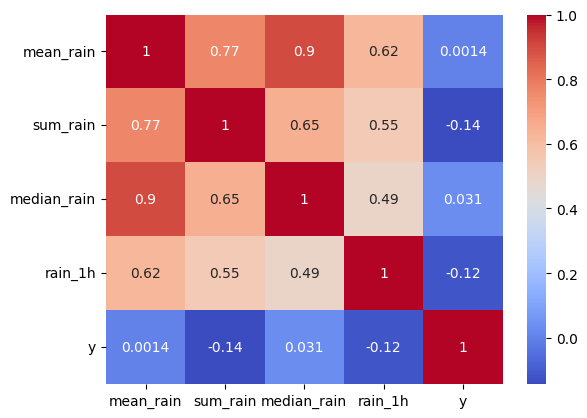

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a DataFrame with the columns you want to calculate the correlation for
data_subset = merged_df[['mean_rain','sum_rain','median_rain','rain_1h','y']]
                       

# calculate the correlation matrix
corr_matrix = data_subset.corr()

# create the heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [94]:
corr_matrix["y"].sort_values(ascending=False)


y              1.000000
median_rain    0.031094
mean_rain      0.001396
rain_1h       -0.121202
sum_rain      -0.143740
Name: y, dtype: float64